# 5.5 다항회귀와 과적합/과소적합 이해

## 다항회귀

휘귀가 독립변수의 단항식이 아닌 2차, 3차 방정식과 같은 다항식으로 표현되는 것을 다항(Polynomial regression)이라 한다. 

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [1]:
X = np.arange(4).reshape(2, 2)
print(X)

poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print(poly_ftr)


[[0 1]
 [2 3]]
[[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [2]:
def polynomial_func(X):
    y = 1 + 2 * X + X ** 2 + X **3
    return y

X = np.arange(4).reshape(2, 2)
print(X)
y = polynomial_func(X)
print(y)

[[0 1]
 [2 3]]
[[ 1  5]
 [17 43]]


In [4]:
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print(poly_ftr)

model = LinearRegression()
model.fit(poly_ftr, y)

print(np.round(model.coef_, 2))
print(model.coef_.shape)

[[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
[[0.   0.02 0.02 0.05 0.07 0.1  0.1  0.14 0.22 0.31]
 [0.   0.06 0.06 0.11 0.17 0.23 0.23 0.34 0.51 0.74]]
(2, 10)


In [3]:
def polynomial_func(X):
    y = 1 + 2 * X + X ** 2 + X **3
    return y

# Pipeline 객체로 간소하게 다항식 피처 변환과 선형회귀를 연결
model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression())])
X = np.arange(4).reshape(2, 2)
y = polynomial_func(X)

model = model.fit(X, y)
print(model.named_steps['linear'].coef_)

[[0.         0.02402402 0.02402402 0.04804805 0.07207207 0.0960961
  0.0960961  0.14414414 0.21621622 0.31231231]
 [0.         0.05705706 0.05705706 0.11411411 0.17117117 0.22822823
  0.22822823 0.34234234 0.51351351 0.74174174]]


#### 잡음이 포함된 다항식을 만들고 차수를 변화시키면서 정확도 예측

In [5]:
# 임의의 값으로 구성된 X값에 대해 코사인 변환 값을 반환.
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# X는 0부터 1까지 30개의 임의의 값을 순서대로 샘플링한 데이터
np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

# y값은 코사인 기반의 true_fun()에서 약간의 노이즈 변동 값을 더한 값
y = true_fun(X) + np.random.randn(n_samples) * 0.1

1회귀계수: [-2.] 2
1MSE: 0.40772896250986834
4회귀계수: [  0. -18.  24.  -7.] 2
4MSE: 0.04320874987231718
15회귀계수: [-2.98300000e+03  1.03900000e+05 -1.87417100e+06  2.03717220e+07
 -1.44873987e+08  7.09318780e+08 -2.47066977e+09  6.24564048e+09
 -1.15677067e+10  1.56895696e+10 -1.54006776e+10  1.06457788e+10
 -4.91379977e+09  1.35920330e+09 -1.70381654e+08] 2
15MSE: 182815433.5604608


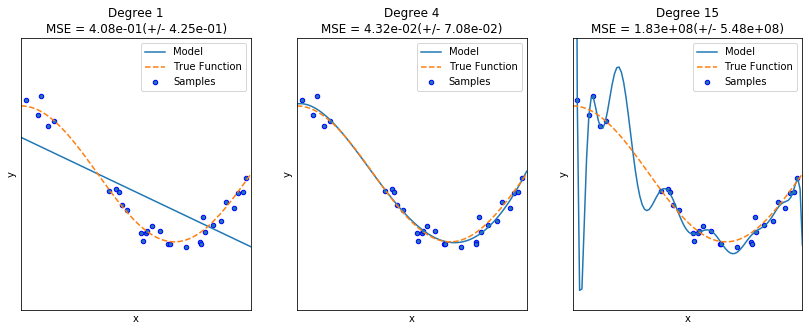

In [13]:
plt.figure(figsize=(14,5))
degrees = [1, 4, 15]

# 다항 회귀의 차수를 1, 4, 15로 각각 변화시키면서 비교
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degress), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    
    
    # 개별 degree별로 Polynomial 반환
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                        ("linear_regression", linear_regression)])
    pipeline.fit(X.reshape(-1, 1), y)
    
    
    # 교차검증
    scores = cross_val_score(pipeline, X.reshape(-1, 1), y, scoring="neg_mean_squared_error", cv=10)
    # Pipeline을 구성하는 세부 객체를 접근하는 named_steps['객체명']을 이용해 회귀계수 추출
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('{}회귀계수:'.format(degrees[i]), np.round(coefficients),2)
    print('{}MSE:'.format(degrees[i]), -1*np.mean(scores))
    
    # 0부터 1까지 테스트 데이터 세트를 100개로 나눠 예측을 수행
    # 체스트 데이터 세트에 회귀 예측을 수행하고 예측 곡선과 실제 곡선을 그려서 비교
    X_test = np.linspace(0, 1, 100)
    # 예측값 곡선
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    # 실제값 곡선
    plt.plot(X_test, true_fun(X_test), '--', label="True Function")
    plt.scatter(X, y, edgecolor='b', s=20, label='Samples')
    
    plt.xlabel("x"); plt.ylabel("y"); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc='best')
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))
    
plt.show()

편향과 분산 그래프에서 왼쪽일 수록 과소적합, 오른쪽일 수록 과적합.<br>
또한, 가장 적합한 중간 지점을 골디락스 지점이라고 한다.
<br>
![](https://t1.daumcdn.net/cfile/tistory/996DB433599AC34225)